# Load packages and initialize the aggregator object (approx 30 mins in Google Colab)

In [ ]:
import pandas as pd
import urllib.request
import re
import numpy as np
import html
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from itertools import islice

# BERT
!pip install transformers
from transformers import BertModel, AutoTokenizer

# Sentence embedding LLM
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search

# Returning URLs with links
!pip install -U duckduckgo_search
from duckduckgo_search import DDGS

# Optional (plotting)
!pip install umap-learn
!pip install d3blocks

In [ ]:
# @title Aggregator object
class aggregator: # Creates a dataframe and updates it

    # Parameters for clustering all text segments returned
    Nclusters = 3

    # Parameters for search
    num_search_results = 100 # Dictates the maximum number of results to be returned
    min_score = 0.3 # For search results, represents minimum cosine similarity between a search query's embedding and embedding of each headline

    # Initialize the BERT model (for segment classification)
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    # Load pre-trained model (weights)
    model = BertModel.from_pretrained('bert-base-uncased',
                                      output_hidden_states = True, # Whether the model returns all hidden-states.
                                      )
    model.eval()
    # Initialize the sentence embedding model (for semantic search)
    sent_model = SentenceTransformer('all-mpnet-base-v2')

    def __init__(self):
      # Prepare the dataframe which will be populated with headlines, state, and site
      self.dataframe = pd.DataFrame()

    def add_newspaper(self, site_: str, state_ : str):
      html_content = self.get_content( site_ ) # Only store the HTML in the scope of this function

      # Check that any HTML content has at least 100 characters
      if len(html_content)>100:
        newspaper_df = self.scrape_page_light( html_content,site_ )
        newspaper_df = newspaper_df.assign( state=state_,site=site_ )
        self.dataframe = pd.concat( [ self.dataframe, newspaper_df ] )

    def get_content(self, url: str ) -> str:
      if re.search('http',url) is None:
        url = f'http://{url}'
      # https://stackoverflow.com/questions/24226781/changing-user-agent-in-python-3-for-urrlib-request-urlopen
      req = urllib.request.Request(
        url,
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
        }
      )
      timeout = 5
      try:
        with urllib.request.urlopen(req, timeout=timeout) as response:
          # Process the response
          html_content = response.read().decode('utf-8')
      except:
        return f'Could not return for {url}' # Empty string returned if no headlines are extracted

      # Otherwise, return the entirety of the html content
      return html_content

    def scrape_page_light(self, html_content: str, site_: str):
      # Store all sentence/phrase like items on the page in a list called 'r'
      r = list()

      # Two types of items
      # (1) content within quotes
      r.extend(  re.findall( '(?<==")[0-9A-Z]+[\w\s\-\(\)&$%]+[ ]+[\w\s\-\(\)&$%]+[ ]+[\w\s\-\(\)&$%]+[^"<\t_=\n\(>]*' ,\
                            html_content )           )
      # (2) content between > and <
      query = re.sub('\n','',html_content)
      r.extend( re.findall( '(?<=>)[0-9A-Z]+[\w\s\-\(\)&$%]+[ ]+[\w\s\-\(\)&$%]+[ ]+[\w\s\-\(\)&$%]+[^"<\t_=\n\(>]*', \
                            query  )            )

      # Adjust each entry in the list 'r'

      # (1) Remove all spaces from beginning and end of story
      r = [ re.sub(r'\\n','',x) for x in r ]
      r = [ re.sub('\s+$|^\s+','',x) for x in r ]

      # (2) Shorten multispaces to single spaces
      r = [ re.sub(r'\s+',' ',x) for x in r ]

      # (3) Un-escape all HTML escape strings before storing as a dataframe and applying filters
      r = [ html.unescape(x) for x in r ]

      # Create a dataframe and sequentially add columns for applying additional filtering criteria
      r_pd = pd.DataFrame({"headlines":r})

      return r_pd

    def retrieve_stories(self,list_of_sites,list_of_states): # Input a list of websites along with states to populate self.dataframe
      [ self.add_newspaper(x,y) for x,y in zip( list_of_sites,list_of_states ) ];

    def prepare_df_embedding(self): # This function will clean up the table that contains hits from all the news sites, so it can go into the embedding

      # We drop duplicates here on the headlines column -- this way, only one row will appear for a given story -- even if it appears in multiple newspapers
      self.dataframe = self.dataframe.drop_duplicates(subset='headlines')

      # Split text and require the number of spaces to exceed min_spaces (in other words, at least min_spaces+1 "word"-like segments)
      min_spaces=3;
      self.dataframe = self.dataframe[ self.dataframe.headlines.apply(lambda x: len(x.split()))>min_spaces ]
      self.dataframe = self.dataframe[ self.dataframe.headlines.apply(lambda x: len(x)<250) ]

      self.dataframe = self.dataframe.reset_index(drop=True)
      self.text_to_embed = self.dataframe.headlines

    def search( self, query: str ):

      query_tensor = self.sent_model.encode( query, convert_to_tensor=True );
      results = semantic_search( query_tensor, self.sentence_embeddings, top_k=self.num_search_results );
      results = [ x for x in np.ravel(results) if x['score']>self.min_score ];

      display(style_table( self.headlines_df.iloc[ [ x['corpus_id'] for x in np.ravel(results)] , : ] ))

    def cluster_embeddings(self):

      self.junk = list()
      self.embeddings = aggregator.get_sentence_embedding( self.text_to_embed )

      embeddings_z = StandardScaler().fit_transform( self.embeddings )
      self.kmeans = KMeans(n_clusters=self.Nclusters, random_state=0, n_init="auto").fit( embeddings_z )

      embedding_ = aggregator.get_sentence_embedding(['Local politicians vote for new law to address the issue'])
      self.keep_label = self.kmeans.predict( embedding_ )

      keep_index = np.squeeze(np.argwhere(self.kmeans.labels_==self.keep_label ).transpose())

      self.headlines_df = self.dataframe.loc[ keep_index, : ]

      junk_labels = list(range(self.Nclusters))
      junk_labels.remove(self.keep_label)

      for x in junk_labels:

        self.junk.append( self.dataframe.loc[ np.squeeze(np.argwhere( self.kmeans.labels_ == x ).transpose() ), : ] )

    def embed_sentences( self ):

      self.sentence_embeddings = aggregator.sent_model.encode( self.headlines_df.headlines.values,convert_to_tensor=True )

    @staticmethod
    def get_link( news_story: str, news_site: str ) -> list:
      number_of_results = 1 # Set this as you wish, if you want more results that match the headline, though 1 makes the most sense
      return [ x['href'] for c,x in enumerate( searcher.text(f'{news_story} site:{news_site}') ) if c<number_of_results ]

    # Methods for returning BERT embeddings
    @staticmethod
    def get_sentence_embedding( input_text: list ) -> np.ndarray:

      embeddings = list()
      for text_ in input_text:
        marked_text = "[CLS] " + text_ + " [SEP]"

        # Load tokenizer and model into get_sentence_embedding function's namespace
        tokenizer = aggregator.tokenizer
        model = aggregator.model

        # Split the sentence into tokens.
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])

        segments_ids = [1] * len(tokenized_text)
        segments_tensors = torch.tensor([segments_ids])

        with torch.no_grad():
            outputs = model( tokens_tensor,segments_tensors )
            hidden_states = outputs[2]

        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        embeddings.append( sentence_embedding )

      return np.vstack( embeddings ) # Convert the list to a matrix

[d3blocks] >INFO> Load pretrained SentenceTransformer: all-mpnet-base-v2
[d3blocks] >INFO> Use pytorch device: cpu


In [ ]:
#@title The newspapers to analyze
newspaper_states = ["Kansas","Wisconsin","Alabama","Alabama","Alabama","Alabama","Alabama","Alabama","Alaska","Alaska","Alaska","Alaska","Alaska","Alaska","Arizona","Arizona","Arizona","Arizona","Arizona","Arizona","Arkansas","Arkansas","Arkansas","Arkansas","Arkansas","Arkansas","Arkansas","Arkansas","California","California","California","California","California","California","California","Colorado","Colorado","Colorado","Colorado","Colorado","Colorado","Colorado","Colorado","Connecticut","Connecticut","Connecticut","Connecticut","Connecticut","Connecticut","Delaware","Delaware","Delaware","Delaware","Delaware","Florida","Florida","Florida","Florida","Florida","Florida","Georgia","Georgia","Georgia","Georgia","Georgia","Georgia","Georgia","Hawaii","Hawaii","Hawaii","Hawaii","Hawaii","Hawaii","Hawaii","Idaho","Idaho","Idaho","Idaho","Idaho","Illinois","Illinois","Illinois","Illinois","Illinois","Illinois","Indiana","Indiana","Indiana","Indiana","Indiana","Iowa","Iowa","Iowa","Iowa","Iowa","Kansas","Kansas","Kansas","Kansas","Kentucky","Kentucky","Kentucky","Kentucky","Louisiana","Louisiana","Louisiana","Louisiana","Louisiana","Maine","Maine","Maine","Maine","Maine","Maine","Maine","Maryland","Maryland","Maryland","Maryland","Maryland","Maryland","Massachusetts","Massachusetts","Massachusetts","Massachusetts","Massachusetts","Massachusetts","Massachusetts","Michigan","Michigan","Michigan","Michigan","Michigan","Michigan","Minnesota","Minnesota","Minnesota","Minnesota","Minnesota","Minnesota","Mississippi","Mississippi","Mississippi","Missouri","Missouri","Missouri","Missouri","Montana","Montana","Montana","Montana","Montana","Nebraska","Nebraska","Nebraska","Nebraska","Nevada","Nevada","Nevada","Nevada","Nevada","New Hampshire","New Hampshire","New Hampshire","New Hampshire","New Hampshire","New Hampshire","New Hampshire","New Jersey","New Jersey","New Mexico","New Mexico","New Mexico","New Mexico","New Mexico","New Mexico","New York","New York","New York","New York","New York","New York","North Carolina","North Carolina","North Carolina","North Dakota","North Dakota","North Dakota","North Dakota","North Dakota","Ohio","Ohio","Ohio","Ohio","Oklahoma","Oklahoma","Oklahoma","Oklahoma","Oklahoma","Oregon","Oregon","Oregon","Oregon","Oregon","Oregon","Oregon","Pennsylvania","Pennsylvania","Pennsylvania","Pennsylvania","Pennsylvania","Pennsylvania","Rhode Island","Rhode Island","South Carolina","South Carolina","South Carolina","South Carolina","South Dakota","South Dakota","South Dakota","South Dakota","South Dakota","Tennessee","Tennessee","Tennessee","Tennessee","Texas","Texas","Texas","Utah","Utah","Utah","Utah","Utah","Vermont","Vermont","Vermont","Vermont","Virginia","Virginia","Virginia","Virginia","Virginia","Virginia","Washington","Washington","Washington","Washington","West Virginia","West Virginia","West Virginia","West Virginia","West Virginia","Wisconsin","Wisconsin","Wisconsin","Wisconsin","Wyoming","Wyoming","Wyoming","Wyoming","Wyoming"]
newspaper_list = ["www.marionrecord.com","www.wausaupilotandreview.com","www.alreporter.com","www.birminghamtimes.com","www.apr.org","www.aldailynews.com","www.yellowhammernews.com","www.annistonstar.com","www.alaskapublic.org","www.adn.com","www.adn.com","www.juneauempire.com","www.newsminer.com","www.alaskanative.net","www.azmirror.com","www.tucsonsentinel.com","www.phoenixnewtimes.com","www.tucson.com","www.kjzz.org","www.coppercourier.com","www.arkansasonline.com","www.arktimes.com","www.talkbusiness.net","www.nwaonline.com","www.arkansaspublicmedia.org","www.amppob.com","www.arkansasbusiness.com","www.ualrpublicradio.org","www.calmatters.org","www.voiceofsandiego.org","www.sfbayview.com","www.capitalandmain.com","www.eastbaytimes.com","www.laist.com","www.mercurynews.com","www.cpr.org/news","www.coloradoindependent.com","www.denverite.com","www.coloradopolitics.com","www.westword.com","www.dailycamera.com","www.csindy.com","www.gazette.com","www.ctmirror.org","www.ctexaminer.com","www.theday.com","www.wnpr.org","www.courant.com","www.newhavenindependent.org","www.delawarepublic.org","www.wdel.com","www.delawarebusinesstimes.com","www.coastalpoint.com","www.delawarestatenews.net","www.floridabulldog.org","www.floridaphoenix.com","www.floridapolitics.com","www.miaminewtimes.com","www.tampabay.com","www.orlandoweekly.com","www.gpbnews.org","www.georgiarecorder.com","www.atlantamagazine.com","www.decaturish.com","www.saportareport.com","www.georgiahealthnews.com","www.thebrunswicknews.com","www.civilbeat.org","www.hawaiipublicradio.org","www.hawaiinewsnow.com","www.westhawaiitoday.com","www.mauinow.com","www.hawaiitribune-herald.com","www.thegardenisland.com","www.idahopress.com","www.idahoednews.org","www.boisedev.com","www.kpvi.com","www.eastidahonews.com","www.propublica.org/illinois","www.chicagoreporter.com","www.blockclubchicago.org","www.capitolnewsillinois.com","www.thedailyline.com","www.southsideweekly.com","www.indianapublicmedia.org","www.wfyi.org","www.indianacitizen.org","www.nuvo.net","www.idsnews.com","www.iowastartingline.com","www.iowapublicradio.org/news","www.thegazette.com","www.littlevillagemag.com","www.iowafarmertoday.com","www.kansasreflector.com","www.kmuw.org","www.ljworld.com","www.hppr.org","www.kycir.org","www.kentuckytoday.com","www.wkms.org","www.wdrb.com","www.thelensnola.org","www.theadvocate.com","www.wwno.org","www.businessreport.com","www.theadvocate.com/acadiana","www.bangordailynews.com","www.mainepublic.org","www.pinetreewatch.org","www.portlandphoenix.me","www.theforecaster.net","www.mainebiz.biz","www.themainemonitor.org","www.marylandmatters.org","www.baltimorebrew.com","www.baltimoresun.com","www.marylandreporter.com","www.wypr.org","www.thedailyrecord.com","www.bostonglobe.com","www.wbur.org","www.baystatebanner.com","www.berkshireeagle.com","www.commonwealthmagazine.org","www.digboston.com","www.wcvb.com","www.bridgemi.com","www.michiganradio.org","www.mlive.com","www.michiganadvance.com","www.record-eagle.com","www.theoaklandpress.com","www.minnpost.com","www.mprnews.org","www.startribune.com","www.twincities.com","www.mndaily.com","www.insightnews.com","www.mississippitoday.org","www.mississippifreepress.org","www.jacksonfreepress.com","www.thepitchkc.com","www.columbiamissourian.com","www.kcur.org","www.riverfronttimes.com","www.montanafreepress.org","www.missoulacurrent.com","www.billingsgazette.com","www.mtpr.org","www.helenair.com","www.omaha.com","www.journalstar.com","www.nebraskaradionetwork.com","www.3newsnow.com","www.reviewjournal.com","www.kunr.org","www.lasvegassun.com","www.thisisreno.com","www.knpr.org","www.nhpr.org","www.unionleader.com","www.concordmonitor.com","www.indepthnh.org","www.sentinelsource.com","www.manchesterinklink.com","www.nhbr.com","www.insidernj.com","www.njmonthly.com","www.nmpoliticalreport.com","www.sfreporter.com","www.abqjournal.com","www.nmindepth.com","www.kunm.org","www.taosnews.com","www.propublica.org","www.thecity.nyc","www.gothamist.com","www.buffalonews.com","www.wnyc.org","www.amsterdamnews.com","www.carolinapublicpress.org","www.wunc.org","www.ncpolicywatch.com","www.prairiepublic.org","www.bismarcktribune.com","www.minotdailynews.com","www.hpr1.com","www.valleynewslive.com","www.citybeat.com","www.daytondailynews.com","www.wosu.org","www.toledoblade.com","www.readfrontier.org","www.kgou.org","www.tulsaworld.com","www.nondoc.com","www.okgazette.com","www.opb.org","www.oregonlive.com","www.streetroots.org","www.wweek.com","www.salemreporter.com","www.eugeneweekly.com","www.ijpr.org","www.spotlightpa.org","www.whyy.org","www.inquirer.com","www.pghcitypaper.com","www.pennlive.com","www.mcall.com","www.rimonthly.com","www.golocalprov.com","www.postandcourier.com","www.postandcourier.com","www.southcarolinapublicradio.org","www.charlestoncitypaper.com","www.sdnewswatch.org","www.sdpb.org","www.dakotafreepress.com","www.rapidcityjournal.com","www.keloland.com","www.tennesseelookout.com","www.nashvillescene.com","www.wpln.org","www.memphisflyer.com","www.texastribune.org","www.dallasnews.com","www.texasobserver.org","www.sltrib.com","www.kuer.org","www.upr.org","www.cityweekly.net","www.deseret.com","www.sevendaysvt.com","www.vpr.org","www.vermontbiz.com","www.valleyreporter.com","www.virginiamercury.com","www.richmond.com","www.roanoke.com","www.cvilletomorrow.org","www.whro.org","www.pilotonline.com","www.crosscut.com","www.thestranger.com","www.kuow.org","www.spokanepublicradio.org","www.wvpublic.org","www.wvgazettemail.com","www.herald-dispatch.com","www.wvmetronews.com","www.mountainstatespotlight.org","www.wisconsinwatch.org","www.wpr.org","www.shepherdexpress.com","www.wisn.com","www.wyomingpublicmedia.org","www.wyofile.com","www.trib.com","www.jhnewsandguide.com","www.county10.com"]

In [ ]:
#@title Instantiation of the my_aggregator object
localnews = aggregator()

localnews.retrieve_stories( newspaper_list,newspaper_states )
localnews.prepare_df_embedding()

localnews.cluster_embeddings()
localnews.embed_sentences()

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

# Search

In [ ]:
localnews.search( 'Legislation about climate' )

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

headlines,state,site
How Fossil Fuel Lobbyists and Their Allies Use ‘Zombie’ Bills and Exploit Loopholes to Avoid Climate Action,California,www.capitalandmain.com
Climate Bill On Newsom’s Desk Would Force Companies To Reveal Carbon Footprint,California,www.laist.com
Fossil Fuel Interests Turn Up Heat Against California Climate Bill,California,www.capitalandmain.com
Sempra is pitching lawmakers on industry-friendly climate solutions paid by ratepayers.,California,www.capitalandmain.com
Noteworthy bills in front of the governor this year.,California,www.laist.com
2023 Has Already Broken The US Record For Billion-Dollar Climate Disasters,California,www.laist.com
Which Bills Will Gavin Newsom Sign Into New California Laws?,California,www.laist.com
Natural gas regs affect everything from food costs to land value | PODIUM,Colorado,www.coloradopolitics.com
Why Ambitious U.S. Emissions Reduction Goals Are Increasingly Out of Reach,California,www.capitalandmain.com
"Industry lobbyists targeting legislators with “myth after myth” to stop emissions disclosure bill, says key environmental group.",California,www.capitalandmain.com


# Optional plots and displays for UMAP

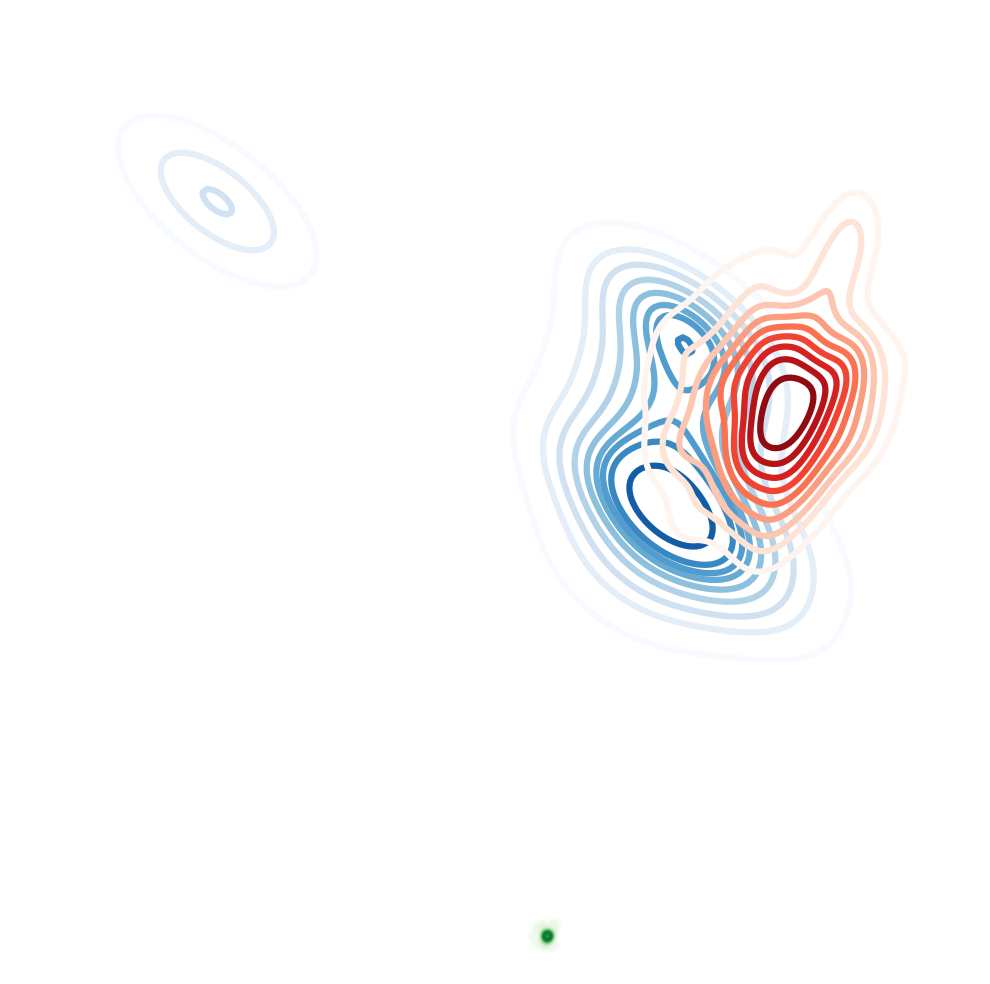

In [ ]:
from umap import UMAP

map_umap = UMAP(densmap=True).fit_transform( localnews.embeddings )

bw = 1 # Bandwidth for display of KDE plot, adjust depending on the number of headlines

fig,ax=plt.subplots(figsize=(4,4),dpi=300)

idx = [ np.squeeze( np.argwhere( localnews.kmeans.labels_==x ) ) for x in range(3) ]

dontkeep = [ x for x in range(3) if x!=localnews.keep_label[0] ] # The kmeans cluster numbers for the discarded clusters

sns.kdeplot(x=map_umap[idx[ dontkeep[0] ],0], y=map_umap[idx[ dontkeep[0] ],1], cmap="Blues", fill=False, bw_adjust=bw)
sns.kdeplot(x=map_umap[idx[ dontkeep[1] ],0], y=map_umap[idx[ dontkeep[1] ],1], cmap="Greens", fill=False, bw_adjust=bw)
sns.kdeplot(x=map_umap[ idx[ localnews.keep_label[0] ],0], y=map_umap[ idx[ localnews.keep_label[0] ],1], cmap="Reds", fill=False, bw_adjust=bw)

plt.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Show the plot
plt.show()

In [ ]:
from d3blocks import D3Blocks
# Initialize
d3 = D3Blocks()

d3.scatter( x=np.round(map_umap[:,0],1), y=np.round(map_umap[:,1],1),color=localnews.kmeans.labels_.astype(int).astype(str),
           tooltip=localnews.text_to_embed,xlim=[0,20],ylim=[0,20],
            filepath='scatter.html') # File saves to Colab directory